<a href="https://colab.research.google.com/github/Zhuoyue-Huang/urop_2022_ml/blob/main/feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""Verify the gradient derivation of linear masked autoencoder."""
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import numpy as np
import pandas as pd 
import scipy.stats as stats

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# set default to be float64
torch.set_default_dtype(torch.float64)

### Model initialisation

In [4]:
# Linear auto-encoder model
class LAE(nn.Module):
    def __init__(self, n, p):
        super(LAE, self).__init__()
        self.n = n
        self.p = p
        self.w1 = nn.Linear(n, p, bias=False)
        self.w2 = nn.Linear(p, n, bias=False)

    def forward(self, y):
        y = self.w1(y)
        y = self.w2(y)
        return y

In [5]:
## Masked lienar auto-encoder model
# Define different types of masks
def mask_basic(prob, sample_num, x_dim):
    return torch.zeros(sample_num, x_dim).bernoulli_(prob)

def mask_dropping_probs(prob_list: torch.Tensor, sample_num, x_dim):
    return torch.zeros(sample_num, x_dim).bernoulli_(prob_list)

def mask_patches_block(prob, patch_size: torch.Tensor, sample_num, sample_dim: torch.Tensor):
    x_dim = sample_dim[0]*sample_dim[1]
    div_check = sample_dim % patch_size == torch.zeros(2)
    if torch.all(div_check):
        pix_num = torch.div(sample_dim, patch_size, rounding_mode='floor')
        mat_patches = torch.zeros(sample_num, *pix_num).bernoulli_(prob)
        mat_patches = torch.repeat_interleave(mat_patches, patch_size[1], dim=2)
        return mat_patches.repeat_interleave(patch_size[0], dim=1).view(sample_num, x_dim)
    else:
        raise NotImplementedError(f"Both height ({sample_dim[0]}) and width ({sample_dim[1]}) should be divisible by patch_size ({patch_size}).")

def mask_patches_plain(prob, patch_size, sample_num, x_dim):
    if not x_dim % patch_size:
        pix_num = x_dim // patch_size
        mat_patches = torch.zeros(sample_num, pix_num).bernoulli_(prob)
        return mat_patches.repeat_interleave(patch_size, dim=1)
    else:
        raise NotImplementedError


# Masked autoencoder (linear)
class M_LAE(nn.Module):
    def __init__(self, prob, x_dim, z_dim, type='basic', patch_size=None, sample_dim=None):
        super(M_LAE, self).__init__()
        self.prob = prob
        if sample_dim is not None:
            self.sample_dim = sample_dim
            self.H, self.W = sample_dim
            self.n = self.H * self.W
        self.n = x_dim
        self.p = z_dim
        if type not in ['basic', 'probs', 'patches']:
            raise NotImplementedError("Could only implement 'basic', 'probs' and 'patches' type of masking.")
        else:
            self.masking_type = type
        if patch_size is not None:
            self.patch_size = patch_size
        w1 = nn.Linear(self.n, self.p, bias=False)
        w2 = nn.Linear(self.p, self.n, bias=False)
        self.body = nn.Sequential(*[w1, w2])
    
    def forward(self, X, mask=None):
        m = X.shape[0]
        if mask is None:
            if self.masking_type == 'basic':
                mask = mask_basic(self.prob, m, self.n).to(device)
            elif self.masking_type == 'probs':
                mask = mask_dropping_probs(self.prob, m, self.n).to(device)
            elif self.masking_type == 'patches':
                mask = mask_patches_plain(self.prob, self.patch_size, m, self.n).to(device)
        Y = mask * X
        Y = self.body(Y)
        return Y

In [12]:
class FE_Net(nn.Module):
    def __init__(self, z_dim, y_dim):
        super(FE_Net, self).__init__()
        self.theta = nn.Linear(z_dim, y_dim, bias=False)

    def forward(self, W):
        return self.theta(W)

In [7]:
def train_loop(data_dict, model, criterion, optimizer, type, epochs=10, sample_average=10, record=True):
    train_loss = []
    val_loss = []
    if type=='encoder':
        train_x = data_dict['train_x']
        train_y = train_x
    elif type=='fe':
        train_x = data_dict['train_x']
        train_y = data_dict['train_y']
        sample_average = 1

    for epoch in range(epochs+1):
        loss_total = 0
        optimizer.zero_grad()
        for i in range(sample_average):
            outputs = model(train_x)
            loss = criterion(outputs, train_y)
            loss_total += loss
        loss_total /= sample_average
        loss_total.backward()
        optimizer.step()
        if record:
          train_loss.append(loss_total.item())
          if epochs>=5 and epoch%(epochs//5)==0:
              v_loss = test_loop(data_dict, model, criterion, type)
              val_loss.append(v_loss)
              print('epoch: ', epoch, ', train loss: ', loss.item(), ', val loss', v_loss)
    if record:
        return {'train_loss': train_loss, 'val_loss': val_loss}
    else:
        return loss_total.item()

def test_loop(data_dict, model, criterion, type):
    if type=='encoder':
        val_x = data_dict['val_x']
        val_y = val_x
    elif type=='fe':
        val_x = data_dict['val_x']
        val_y = data_dict['val_y']

    with torch.no_grad():
        outputs = model(val_x)
        loss = criterion(outputs, val_y)
    return loss.item()

In [8]:
# feature extraction
def feature_extraction(data_dict, model_parameters, criterion, type, epochs=200, device='cuda'):
    train_x, train_y, val_x, val_y = data_dict.values()[:4]

    params = list(model_parameters)
    W1 = params[0].clone().detach()
    train_z = train_x @ W1.T
    val_z = val_x @ W1.T
    z_dim = train_z.shape[1]
    y_dim = train_y.shape[1]

    if type=='ls':
        theta = (torch.inverse(train_z.T @ train_z) @ train_z.T @ train_y).T
        loss = criterion(val_y, val_z @ theta.T)
        return loss.item()
    elif type=='gd':
        data_dict_fe = {'train_x': train_z, 'train_y': train_y,
                        'val_x': val_z, 'val_y': val_y}
        net_fe = FE_Net(z_dim, y_dim).to(device)
        theta = list(net_fe.parameters())
        optimizer = optim.Adam(theta, lr=0.0001)
        ### TRAINING ###
        loss_fe = train_loop(data_dict_fe, net_fe, criterion, optimizer, epochs=epochs, record=False, type='fe')
        return loss_fe

### Dataset

In [18]:
train_num, val_num, test_num = (60, 20, 20)
sample_num_split = (train_num, train_num+val_num)
total = train_num+val_num+test_num

# need to consider x_dim < and > z_dim
z_dim = 10 # dimension of z
H = 8
W = 8
sample_dim = torch.tensor([H, W])
x_dim = H * W
y_dim = z_dim // 2

prob = 0.75
prob_list = torch.rand(x_dim)*0.2 + 0.65
patch_size = torch.tensor([2, 2])

In [20]:
z = torch.normal(mean=0, std=1, size=(total,z_dim)) # here distribution is high dimensional guassian
z = z.to(device)

U = torch.rand(x_dim, z_dim)
U = U.to(device)
V = torch.rand(y_dim, z_dim)
V = V.to(device)

x = z @ U.T
y = z @ V.T
train_x, val_x, test_x = torch.tensor_split(x, sample_num_split)
train_y, val_y, test_y = torch.tensor_split(y, sample_num_split)
data_dict = {'train_x': train_x, 'train_y': train_y, 'val_x': val_x, 'val_y': val_y, 'test_x': test_x, 'test_y': test_y}
fe_loss_dict = {'LAE': [], 'MLAE_basic': [], 'MLAE_probs': [], 'MLAE_patches': []}

torch.Size([20, 64])


In [10]:
learning_rate = 0.01
epochs = 500
epochs_fe = 250

### Get features from autoencoder

In [ ]:
net_LAE = LAE(x_dim, z_dim).to(device)

params = list(net_LAE.parameters())
criterion = nn.MSELoss()
optimizer = optim.Adam(params, lr=learning_rate)

### TRAINING ###
train_loop(data_dict, net_LAE, criterion, optimizer, epochs=epochs, record=False, type='encoder')

# feature extraction
loss_ls = feature_extraction(data_dict, net_LAE.parameters(), criterion, type='ls', epochs=epochs)
loss_gd = feature_extraction(data_dict, net_LAE.parameters(), criterion, type='gd', epochs=epochs)
print('least square loss', loss_ls)
print('gradient decent loss', loss_gd)

least square loss 49.13276788015068
gradient decent loss 0.11213263151369246


In [11]:
net_LAE = LAE(x_dim, z_dim).to(device)

params = list(net_LAE.parameters())
criterion = nn.MSELoss()
optimizer = optim.Adam(params, lr=learning_rate)

### TRAINING ###
train_loop(data_dict, net_LAE, criterion, optimizer, epochs=epochs, record=False, type='encoder')

# feature extraction
loss_ls = feature_extraction(data_dict, net_LAE.parameters(), criterion, type='ls', epochs=epochs)

NameError: ignored

In [ ]:
loss_gd = feature_extraction(data_dict, net_LAE.parameters(), criterion, type='gd', epochs=epochs)

##### Linear autoencoder

In [ ]:
for i in tqdm(range(epochs_fe)):
    net_LAE = LAE(feature_num, reduction_dim).to(device)

    params = list(net_LAE.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    if i==0:
        loss_LAE = train_loop(data_dict, net_LAE, criterion, optimizer, epochs=epochs, record=True, type='encoder')
    else:
        train_loop(data_dict, net_LAE, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_LAE.parameters(), criterion, type='ls', epochs=epochs)
    loss_gd = feature_extraction(data_dict, net_LAE.parameters(), criterion, type='gd', epochs=epochs)
    fe_loss_dict['LAE'].append(loss_gd)

  0%|          | 0/250 [00:00<?, ?it/s]

epoch:  0 , train loss:  1.6110563400342697 , val loss 0.9141163815394789
epoch:  100 , train loss:  0.028172562758704195 , val loss 0.17748618970639496
epoch:  200 , train loss:  0.00612381309925492 , val loss 0.13817017633355144
epoch:  300 , train loss:  0.002311901358287666 , val loss 0.12356291755510251
epoch:  400 , train loss:  0.001131814625302024 , val loss 0.11801111744279658
epoch:  500 , train loss:  0.0006811806210626154 , val loss 0.11401772608661549


100%|██████████| 250/250 [06:49<00:00,  1.64s/it]


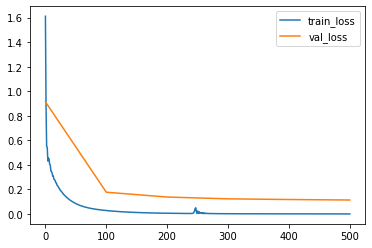

In [ ]:
plt.plot(loss_LAE['train_loss'])
plt.plot(range(0, epochs+1, epochs//5), loss_LAE['val_loss'])
plt.legend(loss_LAE.keys())

##### Masked linear autoencoder (basic)

In [ ]:
for i in tqdm(range(epochs_fe)):
    net_MLAE_basic = M_LAE(prob, sample_dim, reduction_dim).to(device)

    params = list(net_MLAE_basic.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    if i==0:
        loss_MLAE_basic = train_loop(data_dict, net_MLAE_basic, criterion, optimizer, epochs=epochs, record=True, type='encoder')
    else:
        train_loop(data_dict, net_MLAE_basic, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_MLAE_basic.parameters(), criterion, type='ls', epochs=epochs)
    loss_gd = feature_extraction(data_dict, net_MLAE_basic.parameters(), criterion, type='gd', epochs=epochs)
    fe_loss_dict['MLAE_basic'].append(loss_gd)

  0%|          | 0/250 [00:00<?, ?it/s]

epoch:  0 , train loss:  1.3257880439659948 , val loss 0.7784914304374851
epoch:  100 , train loss:  0.07756457746118352 , val loss 0.22514656597019617
epoch:  200 , train loss:  0.06861866331619418 , val loss 0.19182843271407277
epoch:  300 , train loss:  0.0783699920529328 , val loss 0.1866600381324613
epoch:  400 , train loss:  0.07090129153337708 , val loss 0.1867191063804635
epoch:  500 , train loss:  0.07024118678859323 , val loss 0.18434221105772786


100%|██████████| 250/250 [09:15<00:00,  2.22s/it]


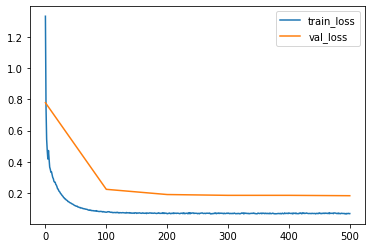

In [ ]:
plt.plot(loss_MLAE_basic['train_loss'])
plt.plot(range(0, epochs+1, epochs//5), loss_MLAE_basic['val_loss'])
plt.legend(loss_MLAE_basic.keys())

##### Masked linear autoencoder (probs)

In [ ]:
for i in tqdm(range(epochs_fe)):
    net_MLAE_probs = M_LAE(prob_list, sample_dim, reduction_dim, type='probs').to(device)

    params = list(net_MLAE_probs.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    if i==0:
        loss_MLAE_probs = train_loop(data_dict, net_MLAE_probs, criterion, optimizer, epochs=epochs, record=True, type='encoder')
    else:
        train_loop(data_dict, net_MLAE_probs, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_MLAE_probs.parameters(), criterion, type='ls', epochs=epochs)
    loss_gd = feature_extraction(data_dict, net_MLAE_probs.parameters(), criterion, type='gd', epochs=epochs)
    fe_loss_dict['MLAE_probs'].append(loss_gd)

  0%|          | 0/250 [00:00<?, ?it/s]

epoch:  0 , train loss:  1.355836491993298 , val loss 0.7263233651897262
epoch:  100 , train loss:  0.07877178861687638 , val loss 0.22245120039611452
epoch:  200 , train loss:  0.06741188408546109 , val loss 0.19691999314004624
epoch:  300 , train loss:  0.07110426195884484 , val loss 0.18745777913139708
epoch:  400 , train loss:  0.07258642358334706 , val loss 0.19792464337732688
epoch:  500 , train loss:  0.06762264993301502 , val loss 0.18367721313837038


100%|██████████| 250/250 [09:42<00:00,  2.33s/it]


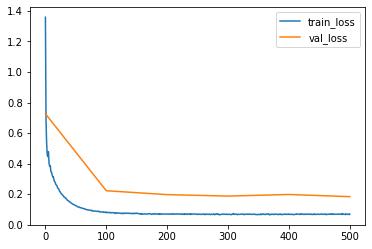

In [ ]:
plt.plot(loss_MLAE_probs['train_loss'])
plt.plot(range(0, epochs+1, epochs//5), loss_MLAE_probs['val_loss'])
plt.legend(loss_MLAE_probs.keys())

##### Masked linear autoencoder (patches)

In [ ]:
patch_dict = {'22': [], '24': [], '42': [], '44': []}

In [ ]:
patch_size = torch.div(sample_dim, 2, rounding_mode='floor')
for i in tqdm(range(epochs_fe)):
    net_MLAE_patches = M_LAE(prob, sample_dim, reduction_dim, type='patches', patch_size=patch_size).to(device)

    params = list(net_MLAE_patches.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    if i==0:
        loss_MLAE_patches = train_loop(data_dict, net_MLAE_patches, criterion, optimizer, epochs=epochs, record=True, type='encoder')
    else:
        train_loop(data_dict, net_MLAE_patches, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_MLAE_patches.parameters(), criterion, type='ls', epochs=epochs)
    loss_gd = feature_extraction(data_dict, net_MLAE_patches.parameters(), criterion, type='gd', epochs=epochs)
    fe_loss_dict['MLAE_patches'].append(loss_gd)
    patch_dict['22'].append(loss_gd)

  0%|          | 0/250 [00:00<?, ?it/s]

epoch:  0 , train loss:  1.3925296568389367 , val loss 0.7370636294631853
epoch:  100 , train loss:  0.17040031385565105 , val loss 0.2720067918102285
epoch:  200 , train loss:  0.15717951366401262 , val loss 0.25857679614693513
epoch:  300 , train loss:  0.10631216678392111 , val loss 0.2857105087219251
epoch:  400 , train loss:  0.1806177605799824 , val loss 0.25058826716587346
epoch:  500 , train loss:  0.159000942931161 , val loss 0.30227158900919965


100%|██████████| 250/250 [13:14<00:00,  3.18s/it]


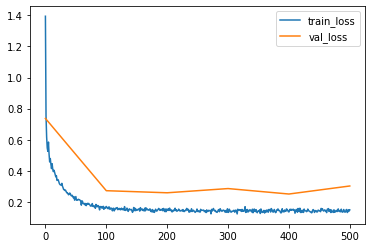

In [ ]:
plt.plot(loss_MLAE_patches['train_loss'])
plt.plot(range(0, epochs+1, epochs//5), loss_MLAE_patches['val_loss'])
plt.legend(loss_MLAE_patches.keys())

In [ ]:
patch_size = torch.div(sample_dim, torch.tensor([2, 4]), rounding_mode='floor')
for i in tqdm(range(epochs_fe)):
    net_MLAE_patches = M_LAE(prob, sample_dim, reduction_dim, type='patches', patch_size=patch_size).to(device)

    params = list(net_MLAE_patches.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    if i==0:
        loss_MLAE_patches = train_loop(data_dict, net_MLAE_patches, criterion, optimizer, epochs=epochs, record=True, type='encoder')
    else:
        train_loop(data_dict, net_MLAE_patches, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_MLAE_patches.parameters(), criterion, type='ls', epochs=epochs)
    loss_gd = feature_extraction(data_dict, net_MLAE_patches.parameters(), criterion, type='gd', epochs=epochs)
    fe_loss_dict['MLAE_patches'].append(loss_gd)
    patch_dict['24'].append(loss_gd)

  0%|          | 0/250 [00:00<?, ?it/s]

epoch:  0 , train loss:  1.4244827293142341 , val loss 0.8900320925606332
epoch:  100 , train loss:  0.11994025697633422 , val loss 0.2541695538785206
epoch:  200 , train loss:  0.10752900689120005 , val loss 0.29242040540747727
epoch:  300 , train loss:  0.10474137068496532 , val loss 0.2829531125386288
epoch:  400 , train loss:  0.10345684138537181 , val loss 0.2662443284116839
epoch:  500 , train loss:  0.09647288976662288 , val loss 0.2590857637916976


100%|██████████| 250/250 [12:58<00:00,  3.11s/it]


In [ ]:
patch_size = torch.div(sample_dim, torch.tensor([4, 2]), rounding_mode='floor')
for i in tqdm(range(epochs_fe)):
    net_MLAE_patches = M_LAE(prob, sample_dim, reduction_dim, type='patches', patch_size=patch_size).to(device)

    params = list(net_MLAE_patches.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    if i==0:
        loss_MLAE_patches = train_loop(data_dict, net_MLAE_patches, criterion, optimizer, epochs=epochs, record=True, type='encoder')
    else:
        train_loop(data_dict, net_MLAE_patches, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_MLAE_patches.parameters(), criterion, type='ls', epochs=epochs)
    loss_gd = feature_extraction(data_dict, net_MLAE_patches.parameters(), criterion, type='gd', epochs=epochs)
    fe_loss_dict['MLAE_patches'].append(loss_gd)
    patch_dict['42'].append(loss_gd)

  0%|          | 0/250 [00:00<?, ?it/s]

epoch:  0 , train loss:  1.4533293512874879 , val loss 0.8924475756550074
epoch:  100 , train loss:  0.14289964327076132 , val loss 0.26438558964155023
epoch:  200 , train loss:  0.10615519735194529 , val loss 0.2522292924913096
epoch:  300 , train loss:  0.10592486057251634 , val loss 0.25126169337975135
epoch:  400 , train loss:  0.10962539470195541 , val loss 0.2802277034939031
epoch:  500 , train loss:  0.1248438637834709 , val loss 0.2655424019710472


100%|██████████| 250/250 [12:56<00:00,  3.11s/it]


In [ ]:
patch_size = torch.div(sample_dim, 4, rounding_mode='floor')
for i in tqdm(range(epochs_fe)):
    net_MLAE_patches = M_LAE(prob, sample_dim, reduction_dim, type='patches', patch_size=patch_size).to(device)

    params = list(net_MLAE_patches.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    if i==0:
        loss_MLAE_patches = train_loop(data_dict, net_MLAE_patches, criterion, optimizer, epochs=epochs, record=True, type='encoder')
    else:
        train_loop(data_dict, net_MLAE_patches, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_MLAE_patches.parameters(), criterion, type='ls', epochs=epochs)
    loss_gd = feature_extraction(data_dict, net_MLAE_patches.parameters(), criterion, type='gd', epochs=epochs)
    fe_loss_dict['MLAE_patches'].append(loss_gd)
    patch_dict['44'].append(loss_gd)

  0%|          | 0/250 [00:00<?, ?it/s]

epoch:  0 , train loss:  1.4255241543436383 , val loss 0.8007183820601287
epoch:  100 , train loss:  0.13039747063773116 , val loss 0.2754919177559386
epoch:  200 , train loss:  0.11901162276561394 , val loss 0.2745816013883953
epoch:  300 , train loss:  0.11604472780943742 , val loss 0.25131434071896347
epoch:  400 , train loss:  0.10375648928473029 , val loss 0.2809909701229763
epoch:  500 , train loss:  0.10462775838724817 , val loss 0.2580946341594131


100%|██████████| 250/250 [12:58<00:00,  3.11s/it]


### Evaluation

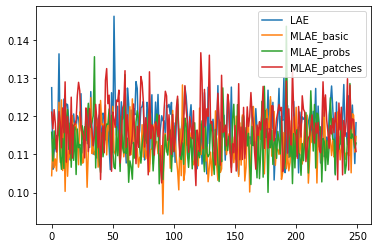

In [ ]:
plt.plot(fe_loss_dict['LAE'])
plt.plot(fe_loss_dict['MLAE_basic'])
plt.plot(fe_loss_dict['MLAE_probs'])
plt.plot(fe_loss_dict['MLAE_patches'])
plt.legend(['LAE', 'MLAE_basic', 'MLAE_probs', 'MLAE_patches'])

In [ ]:
fe_stats_dict = {'LAE': {'mean': statistics.mean(fe_loss_dict['LAE']), 'sd': statistics.stdev(fe_loss_dict['LAE'])},
                 'MLAE_basic': {'mean': statistics.mean(fe_loss_dict['MLAE_basic']), 'sd': statistics.stdev(fe_loss_dict['MLAE_basic'])},
                 'MLAE_probs': {'mean': statistics.mean(fe_loss_dict['MLAE_probs']), 'sd': statistics.stdev(fe_loss_dict['MLAE_probs'])},
                 'MLAE_patches': {'mean': statistics.mean(fe_loss_dict['MLAE_patches']), 'sd': statistics.stdev(fe_loss_dict['MLAE_patches'])}}
print(fe_stats_dict)

{'LAE': {'mean': 0.11711120344995622, 'sd': 0.006192273792688416}, 'MLAE_basic': {'mean': 0.11242539964732247, 'sd': 0.005559274631809486}, 'MLAE_probs': {'mean': 0.11344288484728231, 'sd': 0.006058766885491044}, 'MLAE_patches': {'mean': 0.11739819623717052, 'sd': 0.0065601003835967266}}


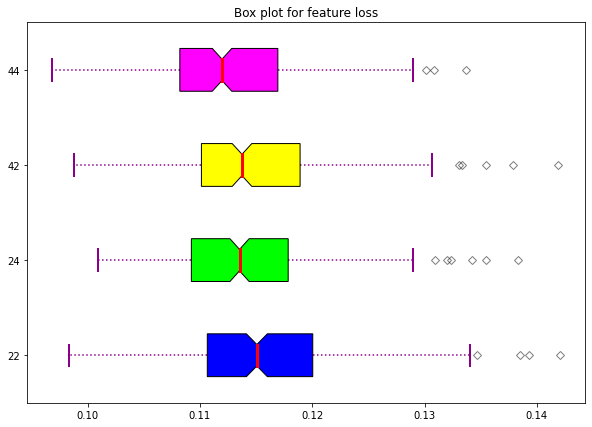

In [ ]:
#data = fe_loss_dict.values()
data = patch_dict.values()
 
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True,
                notch ='True', vert = 0)
 
colors = ['#0000FF', '#00FF00',
          '#FFFF00', '#FF00FF']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
#ax.set_yticklabels(fe_loss_dict.keys())
ax.set_yticklabels(patch_dict.keys())
 
# Adding title
plt.title("Box plot for feature loss")
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
# show plot
plt.show()